# Evaluation of limits for pathlength and global efficiency. Undirected graphs.
Author: **Gorka Zamora-López**

<img src="Images/UPFlogo_smaller.png" style="float:left; width:149px; height:50px"  alt="UPF logo" />
<img src="Images/HBPlogo_smaller.png" style="float:right; width:254px; heigth:50px " alt="HBP logo" />

<br/>
<br/>
<br/>



---------------------

This notebook illustrates how to calculate the upper (ultra-long) and the lower (ultra-short) limits for the average pathlength (and global efficiency) of complex networks using the Python package [PathLims](https://github.com/gorkazl/PathLims). The notebook reproduces, for illustration, some of the results published in the reference:

* G. Zamora-López & R. Brasselet, "*[Sizing complex networks](https://doi.org/10.1038/s42005-019-0239-0)*" Commun Phys **2**:144 (2019)

In this notebook we will:
1. Read an empirical dataset and compute its average pathlength and global efficiency.
3. Estimate the ultra-short and ultra-long limits for average pathlength and global efficiency, given the size $N$ and the number of edges $L$ of the network.
4. Calculate the average pathlength and the global efficiency of random graphs and lattices of same $N$ and $L$.
5. Visualise and compare the results.


--------------------

### Dependencies

The Notebook requires a Python 3.X installation together with *NumPy* and *Matplotlib* libraries. Although *PathLims* works as an stand-alone package, in this example we will use the [GAlib](https://github.com/gorkazl/pyGAlib) package for the manipulation, analysis and
generation of (di)graphs. *GAlib* will be installed from the Python Package Index (PyPI) using `pip`.


#### Import the main libraries

To get started, the first thing we need is to load the libraries we will need to work. Start importing the built-in and third party libraries.



In [1]:
from __future__ import division, print_function

from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import numpy.linalg


#### Import additional libraries

The following cells will check whether *GAlib* and *PathLims* are already installed in the current working environment, otherwise, `pip` will be called for their installation (a working internet connection is required). **NOTE**: The exclamation mark ( ! ) before `pip install galib` indicates the Jupyter Notebook that the current line is a system command, which is then treated as if it were run from a terminal.


In [2]:
## Check if GAlib is installed in the current Python environment, otherwise install
try:
    import galib
except:
    # Install from PyPI
    print('Installing GAlib...')
    ! pip install galib
    import galib

import galib.models
import galib.tools
import galib.metrics_numba

In [4]:
## Check if PathLims is installed in the current environment, otherwise install
try:
    import pathlims
except:
    # Install from the GitHub repository
    print('Installing PathLims...')
    ! pip install pathlims

import pathlims
import pathlims.limits as lims
import pathlims.generators as gens

In [5]:
# Explore the help functions of PathLims
# pathlims?
# pathlims.limits?
# pathlims.generators?

<br/>

### 1. Read a dataset and compute its properties

To start with, we will first load one of the six available empirical undirected networks provided (Human cortico-cortical connectome, collaboration network of Jazz musicians, the Zachary Karate club, the dolphins social network, the Chicago local transportation network and the London transportation network. The datasets are in Pajek format and located in the `Data/` folder.


In [6]:
# Choose one network from ( Und_Human.net, Und_Jazz.net, Und_Zachary.net,
# Und_Dolphins.net, Und_Chicago.net, Und_London.net )
dataroot = 'Data/'
netfname = 'Und_Human.net'
net = galib.tools.LoadFromPajek(dataroot + netfname, getlabels=False)
# Binarise the network and make sure it is undirected
net = np.where(net,1,0).astype(np.uint8)
N = len(net)
assert galib.Reciprocity(net) == 1.0, \
            "Network is directed. Use 'AnalyseDatasets_Directed.py' instead."

# Extract the basic properties of the network
L = 0.5*net.sum()
Lmax = int( 0.5*N*(N-1) )
density = L / Lmax
# Print some feedback
print( 'NETWORK -' , netfname)
print( '\nNumber of nodes, N: %d' %N )
print( 'Number of edges, L: %d' %L ) 
print( 'Density of links: %1.4f' %density )


NETWORK - Und_Human.net

Number of nodes, N: 66
Number of edges, L: 590
Density of links: 0.2751


In [7]:
# CALCULATE THE PATHLENGTH AND EFFICIENCY OF THE NETWORK
# Calculate the pairwise distance matrix and compute average
dij = galib.metrics_numba.FloydWarshall_Numba(net)
dijsum = dij.sum()
if np.isinf(dijsum):
    pathlen_emp = np.inf
else:
    pathlen_emp = float( dijsum - dij.trace() ) / (2*Lmax)
# Calculate efficiency matrix and the average
eij = 1./dij
effic_emp = float( eij.sum() - eij.trace() ) / (2*Lmax)

# Check if network is connected
if dij.max() < N:
    connected = True
else:
    connected = False
print( 'Is the graph connected?', connected )
print( 'Average pathlength: %2.4f' %pathlen_emp )
print( 'Global efficiency:  %2.4f' %effic_emp )


Is the graph connected? True
Average pathlength: 1.8732
Global efficiency:  0.6150


From these numbers alone it is very difficult to interpret whether a network is short or long, or whether it shall be considered as an *small-world* network. For a more complete assessment, these values should be compared to the outcome of other networks. However, since the pathlength and efficiency of any network very much dependent on their size (number of nodes) and density (number of edges) a directed comparison across networks are not always informative. Thus, we need to disentangle the contribution of the network’s internal architecture to the pathlength from the incidental influence contributed by the number of nodes and links.

In the following, we will thus calculate the upper and the lower limits for the pathlength and efficiency that networks of $N$ nodes and $L$ links could possibly take, and the values for equivalent (Erdös-Rènyi) random graphs and ring lattices. All these results will provide a more complete description, allowing us for a more faithful interpretaion of the values observed in the empirical network.


### 2. Estimate the boundaries for the pathlength and global efficiency

The ultra-short and the ultra-long limits represent the solutions to the following optimization problem:

```    
What is the smallest and the largest average pathlength (global efficiency) that
a graph can achieve, given that the graph is made of N nodes and L links?
```

As such, this optimization problem does not impose any assumptions on the generative mechanisms governing how the network should be constructed. If the optimal solutions (the resulting graphs) followed a given generative rule telling how to seed the links to achieve an network, that mechanism is then part of the solution to the problem, not a pre-stablished procedure. This is important in order to distinguish between limits and null-models. 

In the following, we will first calculate the limits, that is, what are the largest and the smallest possible values of average pathlength (or global efficiency) that a graph of $N$ nodes could possibly take given that it contains $L$ edges. The results will be displayed at the end.


In [8]:
# ESTIMATE THE BOUNDARIES FOR PATHLENGTH AND EFFICIENCY
# Ultra-short and ultra-long pathlength
pathlen_us = lims.Pathlen_USgraph(N,L)
pathlen_ul = lims.Pathlen_ULgraph(N,L)

# Ultra-short and ultra-long efficiency
effic_us = lims.Effic_USgraph(N,L)
effic_ul = lims.Effic_ULgraph(N,L, connected=connected)


### 3. Pathlength and efficiency of null-models

Random graphs and ring lattices are two common null-models often employed to evaluate whether a given network shall be classified as small-world or not. The difference with the limits is that apart from a set of constraints (e.g., the resulting graph needs to have $N$ nodes and $L$ edges) null-modes impose a generative mechanism governing the rules by which the edges are seeded on the graph. Random graphs assume that each edge is planted by choosing two nodes at random, from a probability distribution where each node has a given chance to be chosen. In ring-lattices edges are seeded following a deterministic procedure based on the nearest neighbours.

In the following we will calculate the average pathlength and the global efficiency for (Erdös-Rènyi) random graphs and ring lattices with the same number of nodes $N$ and number of edges $L$ as the empirical networks loaded before. For the case of random graphs, we will generate `nrealiz = 100` samples and will then evaluate the ensemble averaged results.

In [9]:
# CALCULATE AVERAGE PATHLENGTH FOR EQUIVALENT RANDOM GRAPHS AND RING LATTICES
# Equivalent random graphs, from ensemble
nrealiz = 100
print( "\nCalculating %d random realizations ..." %nrealiz)

pathlenlist = np.zeros(nrealiz, np.float)
efficlist = np.zeros(nrealiz, np.float)
for re in range(nrealiz):
    # Print some feedback
    if re in np.arange(10,110,10):
        print( re )

    # Generate a random graph
    randnet = galib.models.RandomGraph(N,L, directed=False)
    # Calculate distance matrix and the average pathlength
    rdij = galib.metrics_numba.FloydWarshall_Numba(randnet)
    rdijsum = rdij.sum()
    if np.isinf(rdijsum):
        pathlenlist[re] = np.inf
    else:
        pathlenlist[re] = ( rdijsum - rdij.trace() ) / (N*(N-1))
    # Calculate efficiency matrix and efficiency
    reij = 1./rdij
    efficlist[re] = ( reij.sum() - reij.trace() ) / (N*(N-1))
print( 'Finished.' )

# Calculate the ensemble average pathlength. Ignore disconnected random graphs
goodidx = np.where(pathlenlist < np.inf)[0]
if goodidx.size > 0:
    pathlen_rand = pathlenlist[goodidx].mean()
else:
    pathlen_rand = np.nan
nbad = nrealiz - goodidx.size
if nbad:
    print( '%d disconnected random graph(s) found out of %d realizations' %(nbad,nrealiz) )
    print( 'Discarding them from calculation of ensemble average pathlength' )
# Calculate the ensemble average pathlength
effic_rand = efficlist.mean()



Calculating 100 random realizations ...
10
20
30
40
50
60
70
80
90
Finished.


In [10]:
# Equivalent 1D ring lattices
# Generate a ring lattice of same size and number of edges as the empirical network
latt = galib.models.Lattice1D_FixLinks(N,L)
# Calculate its distance matrix and the average pathlength
ldij = galib.metrics_numba.FloydWarshall_Numba(latt)
pathlen_latt = ( ldij.sum() - ldij.trace() ) / (N*(N-1))
# Calculate the efficiency matrix and the average
leij = 1. / ldij
effic_latt = ( leij.sum() - leij.trace() ) / (N*(N-1))


### 4. Summarise and visualise the results

Finally, we can compare the values obtained for the empirical network together with the limits and with the outcome for different null-models in order to reveal the position every value takes in the space of possible outcomes.

In [11]:
# Print the numerical results
print( '\nRESULTS --------------------------------------' )
print( '\t\tPathlength\tEfficiency' )
print( 'Ultra-short\t%2.4f\t\t%2.4f' %(pathlen_us, effic_us) )
print( 'Random\t\t%2.4f\t\t%2.4f'   %(pathlen_rand, effic_rand) )
print( 'Empirical\t%2.4f\t\t%2.4f'  %(pathlen_emp, effic_emp) )
print( 'Lattice\t\t%2.4f\t\t%2.4f'  %(pathlen_latt, effic_latt) )
print( 'Ultra-long\t%2.4f\t\t%2.4f' %(pathlen_ul, effic_ul) )



RESULTS --------------------------------------
		Pathlength	Efficiency
Ultra-short	1.7249		0.6375
Random		1.7295		0.6368
Empirical	1.8732		0.6150
Lattice		2.3497		0.5480
Ultra-long	11.7128		0.3552


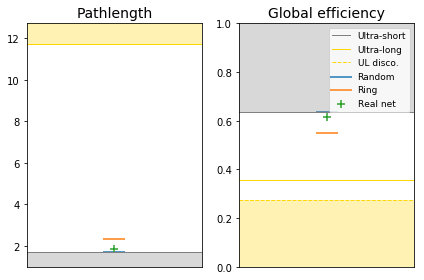

In [12]:
# Plot the results for visualization
plt.figure()

# Plot the PATHLENGTH
plt.subplot(1,2,1)
plt.title('Pathlength', fontsize=14)
plt.axhline(y=1, linewidth=1.0, color='gray')
# Plot the boundaries
plt.axhline(y=pathlen_us, linewidth=1.0, color='gray', label='Ultra-short')
plt.axhspan(1, pathlen_us, facecolor='gray', alpha=0.3)
plt.axhline(y=pathlen_ul, linewidth=1.0, color='gold', label='Ultra-long')
plt.axhspan(pathlen_ul, pathlen_ul+5, facecolor='gold', alpha=0.3)
# Plot the random and lattice
plt.scatter(1,pathlen_rand, marker='_', s=500, label='Random')
plt.scatter(1,pathlen_latt, marker='_', s=500, label='Ring')
# Plot the empirical data
plt.scatter(1,pathlen_emp, marker='+', s=50, label='Real net')
plt.xticks(())
plt.ylim(1,pathlen_ul+1)

# Plot the EFFICIENCY
plt.subplot(1,2,2)
plt.title('Global efficiency', fontsize=14)
# Plot the boundaries
plt.axhline(y=effic_us, linewidth=1.0, color='gray', label='Ultra-short')
plt.axhspan(effic_us, 1, facecolor='gray', alpha=0.3)
plt.axhline(y=effic_ul, linewidth=1.0, color='gold', label='Ultra-long')
plt.axhline(y=density, ls='dashed', linewidth=1.0, color='gold', label='UL disco.')
plt.axhspan(0, density, facecolor='gold', alpha=0.3)
# Plot the random and lattice
plt.scatter(1,effic_rand, marker='_', s=500, label='Random')
plt.scatter(1,effic_latt, marker='_', s=500, label='Ring')
# Plot the empirical data
plt.scatter(1,effic_emp, marker='+', s=50, label='Real net')
plt.xticks(())
plt.ylim(0,1)

plt.legend(loc='upper right', fontsize=9)

plt.tight_layout()
